In [1]:
import pandas as pd
import numpy as np

In [2]:
# Reading data from 'accounts.csv', 'balance.csv' & 'txns.csv' into DataFrames

df_accounts = pd.read_csv('accounts.csv')
df_balance = pd.read_csv('balance.csv')
df_txns = pd.read_csv('txns.csv')

pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x))

df_balance["balance_date"] = pd.to_datetime(df_balance["balance_date"])

df_txns["value_date"] = pd.to_datetime(df_txns["value_date"])
df_txns["transaction_date"] = pd.to_datetime(df_txns["transaction_date"])
df_txns["booking_date"] = pd.to_datetime(df_txns["booking_date"])

In [5]:
# Finding Anomalies
df_balance[["balance", "debits", "credits"]].describe()
df_txns["amount"].describe()

count   18658
mean        0
std        19
min      -453
25%        -0
50%        -0
75%        -0
max       447
Name: amount, dtype: float64

In [4]:
# -- Calculate Daily Average Balance -- 

df_balance_calc = df_balance[["balance_date", "balance"]]
df_balance_calc.set_index("balance_date", inplace =True)

# For Dashboard Purpose
da_average_balance = df_balance_calc["balance"].resample('D').mean().to_frame()
tot_da_average_balance = da_average_balance["balance"].mean()
ma_average_balance = df_balance_calc["balance"].resample('ME').mean().to_frame()
tot_ma_average_balance = ma_average_balance["balance"].mean()
ya_average_balance = df_balance_calc["balance"].resample('YE').mean().to_frame()
tot_ya_average_balance = ya_average_balance["balance"].mean()

ya_average_balance.reset_index(inplace = True)

<Axes: xlabel='balance_date'>

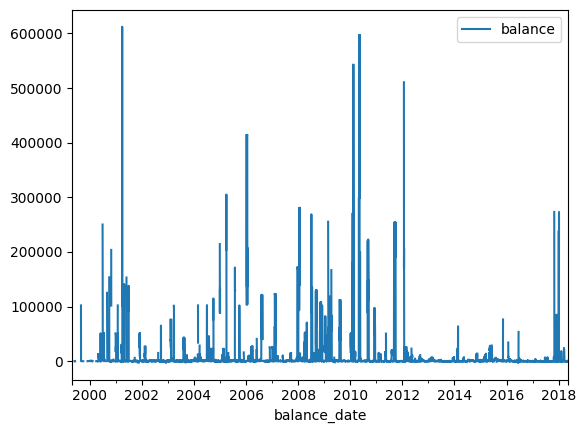

In [9]:
%matplotlib inline
da_average_balance.plot()

In [6]:
# -- Daily Avg number of active accounts --
# df_txns.info()
# df_txns
df_txns_calc = df_txns[["id", "transaction_date", "amount"]]
df_txns_calc.set_index(["transaction_date"], inplace =True)

# For Dashboard Purpose -- Average number of accounts
da_average_active_accounts = df_txns_calc["id"].resample('D').nunique().to_frame()
da_average_active_accounts = da_average_active_accounts["id"].replace(0, np.nan).to_frame()
tot_da_average_active_accounts = da_average_active_accounts.mean()

ma_average_active_accounts = df_txns_calc["id"].resample('ME').nunique().to_frame()
ma_average_active_accounts = ma_average_active_accounts["id"].replace(0, np.nan).to_frame()
tot_ma_average_active_accounts = ma_average_active_accounts.mean()

ya_average_active_accounts = df_txns_calc["id"].resample('YE').nunique().to_frame()
ya_average_active_accounts = ya_average_active_accounts["id"].replace(0, np.nan).to_frame()
tot_ya_average_active_accounts = ya_average_active_accounts.mean()

# tot_ya_average_active_accounts

# For Dashboard Purpose -- Average transaction size

da_average_txn_size = df_txns_calc["amount"].resample('D').mean().to_frame()
tot_da_average_txn_size = da_average_txn_size["amount"].mean()
ma_average_txn_size = df_txns_calc["amount"].resample('ME').mean().to_frame()
tot_ma_average_txn_size = ma_average_txn_size["amount"].mean()
ya_average_txn_size = df_txns_calc["amount"].resample('YE').mean().to_frame()
tot_ya_average_txn_size = ya_average_txn_size["amount"].mean()

<Axes: xlabel='transaction_date'>

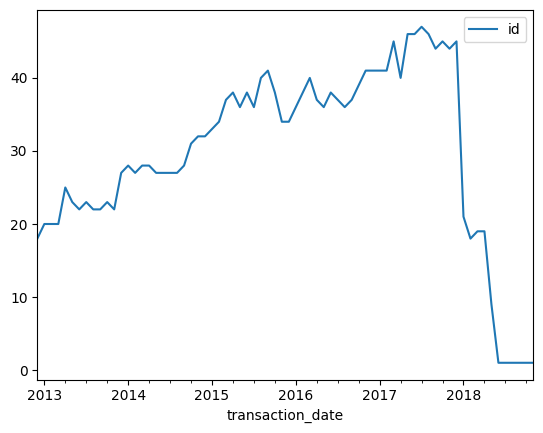

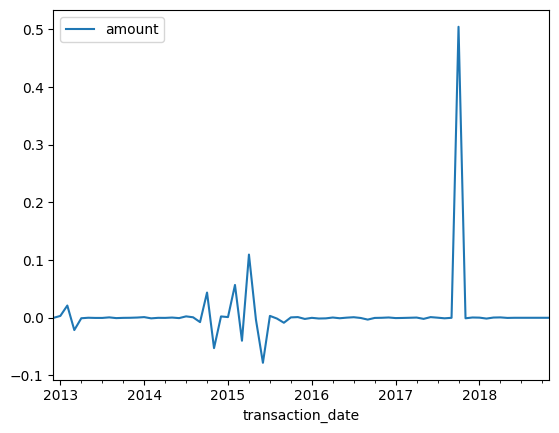

In [10]:
%matplotlib inline
ma_average_active_accounts.plot()
ma_average_txn_size.plot()

In [12]:
# -- Largest drop in Balance compared to avg balance in the same account -- 

# Calculating Average balance for each account
balance_id_group_by = df_balance.groupby(["id"])
average_balance_by_id = balance_id_group_by["balance"].mean()
average_balance_by_id

# Creating a subset for easier calculations
df_balance_subset = df_balance[['id', 'balance_date', 'balance']]

# Merging results
df_balance_drop_increase = pd.merge(df_balance_subset, average_balance_by_id, on = 'id')
df_balance_drop_increase.sort_values(by = ["id", "balance_date"], ascending = True , inplace = True)
df_balance_drop_increase.rename(columns = {'balance_x' : 'balance', 'balance_y' : 'avg_balance'}, inplace = True)
df_balance_drop_increase.head(50)

# Creating an increase drop flag for filtering

# df_balance_drop_increase.info()
df_balance_drop_increase["increase_drop_flag"] = df_balance_drop_increase.apply(lambda x: "Increase" if x['avg_balance'] <= x['balance'] else "Drop", axis = 1)
df_balance_drop_increase["increase_drop_value"] = abs(df_balance_drop_increase['avg_balance'] - df_balance_drop_increase['balance'])
increase_drop_group_by = df_balance_drop_increase.groupby(["increase_drop_flag"])
increase_drop_group_by.max()

,id,balance_date,balance,avg_balance,increase_drop_value
increase_drop_flag,,,,,
Drop,ykaholNazjUF6IieRywg,2018-05-17,5.285288e+05,592843.062731,5.928431e+05
Increase,ykaholNazjUF6IieRywg,2018-05-10,3.824997e+06,592843.062731,3.232154e+06


In [14]:
# Adding previously calculated field -- Adding average balance columns to Balance File

# Please run this section of code only once to avoid duplication of columns

# Putting data into dataframe for merging results

tot_da_average_balance = pd.DataFrame({"tot_da_average_balance" : [tot_da_average_balance]})
tot_ma_average_balance = pd.DataFrame({"tot_ma_average_balance" : [tot_ma_average_balance]})
tot_ya_average_balance = pd.DataFrame({"tot_ya_average_balance" : [tot_ya_average_balance]})
ya_average_balance["balance_date_year"] = pd.to_datetime(ya_average_balance["balance_date"]).dt.year
df_balance_drop_increase["balance_date_year"] = pd.to_datetime(df_balance_drop_increase["balance_date"]).dt.year

# Merging Results

df_balance_drop_increase = pd.merge(df_balance_drop_increase, tot_da_average_balance, how = 'cross')
df_balance_drop_increase = pd.merge(df_balance_drop_increase, tot_ma_average_balance, how = 'cross')
df_balance_drop_increase = pd.merge(df_balance_drop_increase, tot_ya_average_balance, how = 'cross')
df_balance_drop_increase = pd.merge(df_balance_drop_increase, ya_average_balance, on = 'balance_date_year')

In [17]:
# Cleaning Up Balance Table 

df_balance_drop_increase.rename(columns = {"balance_date_x" : "balance_date", "balance_x" : "balance", "balance_y" : "ya_average_balance"}, inplace = True)
df_balance_drop_increase.drop(columns = ["balance_date_y"], inplace = True)
df_balance_drop_increase

,id,balance_date,balance,avg_balance,increase_drop_flag,increase_drop_value,balance_date_year,tot_da_average_balance,tot_ma_average_balance,tot_ya_average_balance,ya_average_balance
0,3OBjfIaphkQ6F8bLxDuoRg,2000-05-09,0.000000,72.914751,Drop,72.914751,2000,11209.668457,10247.117211,11302.563241,18385.582093
1,3OBjfIaphkQ6F8bLxDuoRg,2000-10-03,3.369301,72.914751,Drop,69.545450,2000,11209.668457,10247.117211,11302.563241,18385.582093
2,3OBjfIaphkQ6F8bLxDuoRg,2000-10-06,7.805860,72.914751,Drop,65.108891,2000,11209.668457,10247.117211,11302.563241,18385.582093
3,3OBjfIaphkQ6F8bLxDuoRg,2000-10-07,8.175743,72.914751,Drop,64.739008,2000,11209.668457,10247.117211,11302.563241,18385.582093
4,3OBjfIaphkQ6F8bLxDuoRg,2000-10-11,10.078000,72.914751,Drop,62.836751,2000,11209.668457,10247.117211,11302.563241,18385.582093
...,...,...,...,...,...,...,...,...,...,...,...
22300,ykaholNazjUF6IieRywg,2017-10-01,0.162656,657.005711,Drop,656.843055,2017,11209.668457,10247.117211,11302.563241,3187.684259
22301,ykaholNazjUF6IieRywg,2017-11-01,0.132377,657.005711,Drop,656.873334,2017,11209.668457,10247.117211,11302.563241,3187.684259
22302,ykaholNazjUF6IieRywg,2017-11-22,0.000000,657.005711,Drop,657.005711,2017,11209.668457,10247.117211,11302.563241,3187.684259
22303,ykaholNazjUF6IieRywg,2017-12-01,0.102027,657.005711,Drop,656.903684,2017,11209.668457,10247.117211,11302.563241,3187.684259


In [18]:
# Adding previously calculated field -- Adding average active accounts columns to Transactions File

# Please run this section of code only once to avoid duplication of columns

# Putting data into dataframe for merging results

tot_da_average_active_accounts = tot_da_average_active_accounts.to_frame()
tot_da_average_active_accounts.rename(columns = {0: "tot_da_average_active_accounts"}, inplace = True)
tot_ma_average_active_accounts = tot_ma_average_active_accounts.to_frame()
tot_ma_average_active_accounts.rename(columns = {0: "tot_ma_average_active_accounts"}, inplace = True)
tot_ya_average_active_accounts = tot_ya_average_active_accounts.to_frame()
tot_ya_average_active_accounts.rename(columns = {0: "tot_ya_average_active_accounts"}, inplace = True)
ya_average_active_accounts.reset_index(inplace = True)
ya_average_active_accounts["transaction_date_year"] = pd.to_datetime(ya_average_active_accounts["transaction_date"]).dt.year
df_txns["transaction_date_year"] = pd.to_datetime(df_txns["transaction_date"]).dt.year

# Merging Results

df_txns = pd.merge(df_txns, tot_da_average_active_accounts, how = 'cross')
df_txns = pd.merge(df_txns, tot_ma_average_active_accounts, how = 'cross')
df_txns = pd.merge(df_txns, tot_ya_average_active_accounts, how = 'cross')
df_txns = pd.merge(df_txns, ya_average_active_accounts, on = 'transaction_date_year')

In [19]:
# Cleaning Up Transactions Table 

df_txns.rename(columns = {"id_x" : "id", "transaction_date_x" : "transaction_date", "id_y" : "ya_average_active_accounts"}, inplace = True)
df_txns.drop(columns = ["transaction_date_y"], inplace = True)
df_txns

,id,txn_id,credit_debit_indicator,amount,revr_txn_id,value_date,transaction_date,booking_date,transaction_date_year,tot_da_average_active_accounts,tot_ma_average_active_accounts,tot_ya_average_active_accounts,ya_average_active_accounts
0,xD5BGlG04X3hPpRXDZd0A,q3nLpB2pCvI0F13sisG0fw,DR,-1.012211e-07,NaN,2015-02-01,2015-01-31,2015-01-31,2015,4.665623,29.805556,36.0,43
1,S4KzxjEjOd9tJW1qgS3gw,Xg5Xw6x8slALzbgCnziUVg,DR,-6.614293e-05,NaN,2017-12-07,2017-12-06,2017-12-06,2017,4.665623,29.805556,36.0,52
2,hgKn8WSDSpycaBVhxRMbYw,hTG1i3ymAaxSMcbqkYFaeQ,DR,-2.084883e-07,NaN,2017-04-29,2017-04-28,2017-04-28,2017,4.665623,29.805556,36.0,52
3,q8pD91iekkhOdYCPjPWD9w,BrajWpq2c58m4d7cW7KbQ,DR,-1.993107e-05,NaN,2018-01-17,2018-01-11,2018-01-11,2018,4.665623,29.805556,36.0,23
4,MVezspyBbLMmOINMjVBSlw,yeQNM4fjgolih04zVYeQ7w,CR,8.106027e-07,NaN,2018-01-01,2017-12-30,2017-12-30,2017,4.665623,29.805556,36.0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18653,tQcVzouqvryGlr5d3GzSsQ,aoFXU8O6X48jngE7ePzyA,CR,2.410848e-02,NaN,2014-03-29,2014-03-29,2014-03-29,2014,4.665623,29.805556,36.0,36
18654,knJd4g3Shy8ZplBhSMVzDw,xd0mAZc3dMH88aiE3fd3pA,DR,-2.265226e-06,NaN,2017-07-01,2017-06-30,2017-06-30,2017,4.665623,29.805556,36.0,52
18655,q8pD91iekkhOdYCPjPWD9w,dthzlKzMCN5a2FudY4LTgw,DR,-2.084883e-07,NaN,2018-01-17,2018-01-11,2018-01-11,2018,4.665623,29.805556,36.0,23
18656,tQcVzouqvryGlr5d3GzSsQ,IWIQPHYGfXXnqlCG9Gt2g,DR,-4.063319e-02,NaN,2013-03-23,2013-03-23,2013-03-23,2013,4.665623,29.805556,36.0,32


In [20]:
# Adding previously calculated field -- Adding average Transaction Size columns to Transactions File

# Please run this section of code only once to avoid duplication of columns

# Putting data into dataframe for merging results

tot_da_average_txn_size = pd.DataFrame({"tot_da_average_txn_size" : [tot_da_average_txn_size]})
tot_ma_average_txn_size = pd.DataFrame({"tot_ma_average_txn_size" : [tot_ma_average_txn_size]})
tot_ya_average_txn_size = pd.DataFrame({"tot_ya_average_txn_size" : [tot_ya_average_txn_size]})
ya_average_txn_size.reset_index(inplace = True)
ya_average_txn_size["transaction_date_year"] = pd.to_datetime(ya_average_txn_size["transaction_date"]).dt.year

# Merging Results

df_txns = pd.merge(df_txns, tot_da_average_txn_size, how = 'cross')
df_txns = pd.merge(df_txns, tot_ma_average_txn_size, how = 'cross')
df_txns = pd.merge(df_txns, tot_ya_average_txn_size, how = 'cross')
df_txns = pd.merge(df_txns, ya_average_txn_size, on = 'transaction_date_year')

In [21]:
# Cleaning Up Transactions Table 

df_txns.rename(columns = {"amount_x" : "amount", "transaction_date_x" : "transaction_date", "amount_y" : "ya_average_txn_size"}, inplace = True)
df_txns.drop(columns = ["transaction_date_y"], inplace = True)
df_txns

,id,txn_id,credit_debit_indicator,amount,revr_txn_id,value_date,transaction_date,booking_date,transaction_date_year,tot_da_average_active_accounts,tot_ma_average_active_accounts,tot_ya_average_active_accounts,ya_average_active_accounts,tot_da_average_txn_size,tot_ma_average_txn_size,tot_ya_average_txn_size,ya_average_txn_size
0,xD5BGlG04X3hPpRXDZd0A,q3nLpB2pCvI0F13sisG0fw,DR,-1.012211e-07,NaN,2015-02-01,2015-01-31,2015-01-31,2015,4.665623,29.805556,36.0,43,0.147158,0.007337,0.010312,0.000037
1,S4KzxjEjOd9tJW1qgS3gw,Xg5Xw6x8slALzbgCnziUVg,DR,-6.614293e-05,NaN,2017-12-07,2017-12-06,2017-12-06,2017,4.665623,29.805556,36.0,52,0.147158,0.007337,0.010312,0.072194
2,hgKn8WSDSpycaBVhxRMbYw,hTG1i3ymAaxSMcbqkYFaeQ,DR,-2.084883e-07,NaN,2017-04-29,2017-04-28,2017-04-28,2017,4.665623,29.805556,36.0,52,0.147158,0.007337,0.010312,0.072194
3,q8pD91iekkhOdYCPjPWD9w,BrajWpq2c58m4d7cW7KbQ,DR,-1.993107e-05,NaN,2018-01-17,2018-01-11,2018-01-11,2018,4.665623,29.805556,36.0,23,0.147158,0.007337,0.010312,0.000152
4,MVezspyBbLMmOINMjVBSlw,yeQNM4fjgolih04zVYeQ7w,CR,8.106027e-07,NaN,2018-01-01,2017-12-30,2017-12-30,2017,4.665623,29.805556,36.0,52,0.147158,0.007337,0.010312,0.072194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18653,tQcVzouqvryGlr5d3GzSsQ,aoFXU8O6X48jngE7ePzyA,CR,2.410848e-02,NaN,2014-03-29,2014-03-29,2014-03-29,2014,4.665623,29.805556,36.0,36,0.147158,0.007337,0.010312,0.000164
18654,knJd4g3Shy8ZplBhSMVzDw,xd0mAZc3dMH88aiE3fd3pA,DR,-2.265226e-06,NaN,2017-07-01,2017-06-30,2017-06-30,2017,4.665623,29.805556,36.0,52,0.147158,0.007337,0.010312,0.072194
18655,q8pD91iekkhOdYCPjPWD9w,dthzlKzMCN5a2FudY4LTgw,DR,-2.084883e-07,NaN,2018-01-17,2018-01-11,2018-01-11,2018,4.665623,29.805556,36.0,23,0.147158,0.007337,0.010312,0.000152
18656,tQcVzouqvryGlr5d3GzSsQ,IWIQPHYGfXXnqlCG9Gt2g,DR,-4.063319e-02,NaN,2013-03-23,2013-03-23,2013-03-23,2013,4.665623,29.805556,36.0,32,0.147158,0.007337,0.010312,-0.000049


In [309]:
# df_accounts
# df_txns
# df_balance_drop_increase

,id,balance_date,balance,avg_balance,increase_drop_flag,increase_drop_value,balance_date_year,tot_da_average_balance,tot_ma_average_balance,tot_ya_average_balance,ya_average_balance
0,3OBjfIaphkQ6F8bLxDuoRg,2000-05-09,0.000000,72.914751,Drop,72.914751,2000,11209.668457,10247.117211,11302.563241,18385.582093
1,3OBjfIaphkQ6F8bLxDuoRg,2000-10-03,3.369301,72.914751,Drop,69.545450,2000,11209.668457,10247.117211,11302.563241,18385.582093
2,3OBjfIaphkQ6F8bLxDuoRg,2000-10-06,7.805860,72.914751,Drop,65.108891,2000,11209.668457,10247.117211,11302.563241,18385.582093
3,3OBjfIaphkQ6F8bLxDuoRg,2000-10-07,8.175743,72.914751,Drop,64.739008,2000,11209.668457,10247.117211,11302.563241,18385.582093
4,3OBjfIaphkQ6F8bLxDuoRg,2000-10-11,10.078000,72.914751,Drop,62.836751,2000,11209.668457,10247.117211,11302.563241,18385.582093
...,...,...,...,...,...,...,...,...,...,...,...
22300,ykaholNazjUF6IieRywg,2017-10-01,0.162656,657.005711,Drop,656.843055,2017,11209.668457,10247.117211,11302.563241,3187.684259
22301,ykaholNazjUF6IieRywg,2017-11-01,0.132377,657.005711,Drop,656.873334,2017,11209.668457,10247.117211,11302.563241,3187.684259
22302,ykaholNazjUF6IieRywg,2017-11-22,0.000000,657.005711,Drop,657.005711,2017,11209.668457,10247.117211,11302.563241,3187.684259
22303,ykaholNazjUF6IieRywg,2017-12-01,0.102027,657.005711,Drop,656.903684,2017,11209.668457,10247.117211,11302.563241,3187.684259


In [22]:
# Writing Modified Data into an Excel file for Power BI Dashboarding

with pd.ExcelWriter('MUFG_Required_Assignment_Pandas_Output.xlsx') as writer:
    df_accounts.to_excel(writer, sheet_name = 'df_accounts', index = False)
    df_txns.to_excel(writer, sheet_name = 'df_txns', index = False)
    df_balance_drop_increase.to_excel(writer, sheet_name = 'df_balance', index = False)